### 필요한 모듈 가져오기

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
tqdm.pandas()
np.set_printoptions(5,)

assert int(tf.__version__[0]) == 2, "tensorflow 2.x대에서 동작합니다."

### 데이터 가져오기 

데이터는 last.fm 데이터셋입니다.

In [2]:
from tensorflow.keras.utils import get_file

ROOT_URL = "https://craftsangjae.s3.ap-northeast-2.amazonaws.com/data/"

# 데이터 가져오기
play_path = get_file("lastfm_play.csv",
                     ROOT_URL+"lastfm_play.csv")
artist_path = get_file("lastfm_artist.csv",
                       ROOT_URL+"lastfm_artist.csv")
user_path = get_file("lastfm_user.csv",
                     ROOT_URL+"lastfm_user.csv")

play_df = pd.read_csv(play_path)
artist_df = pd.read_csv(artist_path)
user_df = pd.read_csv(user_path)

## 모델 구성하기

### 1. 주요 Hyper-Parameter 

##### 주의점


* `user_id`와 `artist_id`를 바로 index로 쓰기 위해 아래와 같이 구성

In [3]:
num_user = play_df.user_id.max() + 1 # user id 가짓 수
num_item = play_df.artist_id.max() + 1 # item id 가짓 수
num_factor = 32 # 사용할 Factor의 크기

### 2. `Embedding` 레이어 추가하기

##### 주의점

* `implicit`의 초기화 규칙을 따랐음
* 수식의 가독성을 위해 아이템에 대한 bias항과 embedding 항을 분리. 

In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import RandomUniform

user_id = Input(shape=(), dtype=tf.int32, name='user')  
pos_item_id = Input(shape=(), dtype=tf.int32, name='pos_item')
neg_item_id = Input(shape=(), dtype=tf.int32, name='neg_item') 

# 초기화 함수 : Uniform 분포
init_range = 1 / (2*num_factor)
initializer = RandomUniform(minval=-init_range, maxval=init_range)

# Embedding Layer 선언하기
user_embedding_layer = Embedding(num_user, num_factor, 
                                 embeddings_initializer=initializer,
                                 name='user_embedding')
item_embedding_layer = Embedding(num_item, num_factor, 
                                 embeddings_initializer=initializer,
                                 name='item_embedding')
item_bias_layer = Embedding(num_item, 1, 
                            embeddings_initializer='zeros',
                            name='item_bias')

### 3. `pos_score`와 `neg_score` 연산하기

In [5]:
from tensorflow.keras.layers import Dot

user_embedding = user_embedding_layer(user_id)

pos_item_embedding = item_embedding_layer(pos_item_id)
neg_item_embedding = item_embedding_layer(neg_item_id)

pos_item_bias = item_bias_layer(pos_item_id)
neg_item_bias = item_bias_layer(neg_item_id)

pos_score = (
    Dot(axes=(1,1))([user_embedding, pos_item_embedding]) + pos_item_bias)
neg_score = (
    Dot(axes=(1,1))([user_embedding, neg_item_embedding]) + neg_item_bias)

score = pos_score - neg_score

### 4. 모델 선언하기

##### 주의점

* 아래와 같이 input이 dict이면, 모델에 입력데이터를 넣을 때에도 dict로 넣어주어야 함

In [6]:
from tensorflow.keras.models import Model

inputs = {
    "user": user_id,
    "pos_item": pos_item_id,
    "neg_item": neg_item_id
}

model = Model(inputs, score, name='bpr')

### 5. 정규화 항 추가하기

##### 주의점

* `implicit`의 default l2 정규화 항이 0.01로 세팅되어 있음, 이와 동일하게 세팅
* `Embedding`레이어의 `embeddings_regularizers`에 정규화 항을 추가할 경우, 연산에 포함되지 않은 weight마저도 weight decay가 적용됨.
     - 예를 들어, user_id=13, pos_item_id=15,neg_item_id=17이면, $embed_{user =13}$,$embed_{item=15}$,$embed_{item=17}$만 weight decay되어야 하는데, 그외 임베딩 변수도 전부 포함

In [7]:
from tensorflow.keras import backend as K

l2_reg = 1e-1

# user embedding Regularization
user_reg = l2_reg *(
    K.sum(user_embedding**2))

model.add_loss(user_reg)

# item embedding regularization 
item_reg = l2_reg * (
    K.sum(pos_item_embedding**2) 
    + K.sum(neg_item_embedding**2))

model.add_loss(item_reg)

# item bias regulairzation
bias_reg = l2_reg * (
    K.sum(pos_item_bias**2) 
    + K.sum(neg_item_bias**2))

model.add_loss(bias_reg)

### 6. 손실함수와 옵티마이저 세팅하기

##### 주의점

* **논문 내 수식을 참조**
    
    시그모이드 함수에 바로 로그함수를 씌운 것을 손실함수로 이용했다는 것을 볼 수 있음. 그리고 평균이 아닌 합계로 aggregation함.
    
    $
    \mbox{BPR-OPT} := \sum_{(u,i,j)\in D_S}  \ln\sigma(\hat x_{uij}) - \lambda_{\Theta}||\Theta||^2
    $
    
* 모델의 출력값은 ($-\infty, +\infty$) 범위의 출력값으로, 양수이면 True, 음수이면 False가 됨. BinaryAccuracy의 threshold은 0이 되어야 함

In [8]:
from tensorflow.keras import backend as K

@tf.function
def log_sigmoid(y_true, y_pred): 
    return -K.sum(K.log(K.sigmoid(y_pred)))

정규화항의 크기를 추적하기 위해 아래와 같이 metric 함수를 구성

In [9]:
def user_reg(x,y):
    return model.losses[0]/l2_reg

def item_reg(x,y):
    return model.losses[1]/l2_reg
    
def bias_reg(x,y):
    return model.losses[2]/l2_reg

각각 항에 대한 정규화항 크기, 목적함수인 log sigmoid, 정확도를 metric으로 삼음

In [10]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import BinaryAccuracy

lr = 1e-2

metrics = [user_reg, item_reg, bias_reg, 
           log_sigmoid, BinaryAccuracy(threshold=0.)]

model.compile(SGD(lr),
              loss=log_sigmoid,
              metrics=metrics)

### 7. 데이터 파이프라인 구성하기

BPR의 손실함수인 Triplet Loss를 계산하기 위해서는 Negative Case를 Bootstraping 해주어야 함. 

In [11]:
@tf.function
def negative_sampling(user_id, pos_item_id):
    global num_item
    batch_size = tf.shape(user_id)[0]
    
    # 무작위로 item_id 생성하기 (negative sampling)    
    neg_item_id = tf.random.uniform(
        (batch_size, ), maxval=num_item, dtype=tf.int32)
    
    X = {
        "user":user_id,
        "pos_item":pos_item_id,
        "neg_item":neg_item_id
    }
    
    # 더미 변수
    Y = tf.ones((batch_size, 1)) 
    return X, Y

#### $\color{red}{\text{주의점}}$

* `implicit`과 달리 SGD가 아닌 mini-batch SGD를 활용함. 

In [12]:
batch_size = 1024

shuffled = play_df.sample(frac=1)
user_ids = shuffled.user_id.values
item_ids = shuffled.artist_id.values

dataset = (
    tf.data.Dataset
    .from_tensor_slices((user_ids, item_ids))
    .shuffle(batch_size*100) # 데이터 내 순서 shuffling
    .batch(batch_size) # 배치 단위로 record 묶기
    .map(negative_sampling))

### 8. 모델 학습시키기

##### 문제점

* 정확도가 너무 빠르게 올라감, `implicit` 같은 경우 5 epoch 정도가 소요됨
* `bias_reg`가 꾸준히 상승(bias 항의 크기가 계속 커진다는 의미)

In [13]:
model.fit(dataset, epochs=5)

Epoch 1/5
16898/16898 [==============================] - 106s 6ms/step - loss: 479.2418 - user_reg: 0.2424 - item_reg: 0.2625 - bias_reg: 85.0453 - log_sigmoid: 393.6686 - binary_accuracy: 0.9515
Epoch 2/5
16898/16898 [==============================] - 106s 6ms/step - loss: 437.6945 - user_reg: 0.1990 - item_reg: 0.1394 - bias_reg: 96.6183 - log_sigmoid: 340.7177 - binary_accuracy: 0.9572
Epoch 3/5
16898/16898 [==============================] - 104s 6ms/step - loss: 423.5769 - user_reg: 0.1635 - item_reg: 0.0838 - bias_reg: 98.4566 - log_sigmoid: 324.8524 - binary_accuracy: 0.9579
Epoch 4/5
16898/16898 [==============================] - 108s 6ms/step - loss: 416.4214 - user_reg: 0.1346 - item_reg: 0.0517 - bias_reg: 101.0888 - log_sigmoid: 315.1241 - binary_accuracy: 0.9582
Epoch 5/5
16898/16898 [==============================] - 116s 7ms/step - loss: 412.7215 - user_reg: 0.1109 - item_reg: 0.0324 - bias_reg: 103.9482 - log_sigmoid: 308.6114 - binary_accuracy: 0.9583


##### 문제점

* `item_bias`가 너무 큼, `item_bias`를 위주로 모델이 학습

In [14]:
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
item_embeddings = model.get_layer('item_embedding').get_weights()[0]
item_bias = model.get_layer('item_bias').get_weights()[0]

print("user 임베딩 변수 별 벡터 크기 : ", np.mean(
    np.linalg.norm(user_embeddings,axis=0)))
print("item 임베딩 변수 별 벡터 크기 : ", np.mean(
    np.linalg.norm(item_embeddings,axis=0)))
print("item bias 변수의 벡터 크기 : ", np.mean(
    np.linalg.norm(item_bias,axis=0)))

user 임베딩 변수 별 벡터 크기 :  3.3737223
item 임베딩 변수 별 벡터 크기 :  1.0686212
item bias 변수의 벡터 크기 :  247.75345


분포를 보면 bias는 넓게 퍼진 것을 볼수 있고, embedding은 0 근처에 몰려 있는 것을 볼수 있음.

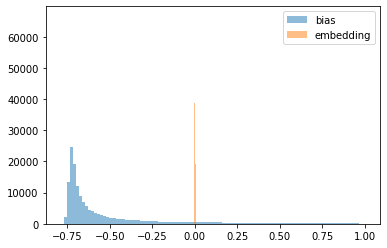

In [15]:
plt.hist(item_bias,bins=100,
         alpha=0.5,label='bias')
plt.hist(item_embeddings.flatten(), bins=200, 
         alpha=0.5,label='embedding')
plt.legend()
plt.show()

### 9. 모델 평가하기

##### 문제점

* 아예 모르는 사람들이 등장함

In [16]:
artist_embedding_df = pd.DataFrame(item_embeddings,
                                   index=artist_df.artist_name)
target_embedding = artist_embedding_df.loc['madonna']

(
    artist_embedding_df
    .dot(target_embedding)
    .sort_values(ascending=False)
    .iloc[:10]
)

artist_name
bombardiers         0.000013
eurogroove          0.000012
truth & soul        0.000011
handpolished        0.000011
black rabbit        0.000011
thee hypnotics      0.000011
long john hunter    0.000011
hal blaine          0.000011
张智成                 0.000011
synthetic 16        0.000011
dtype: float32

## implicit과의 비교대조 
Hyper-parameter 들을 최대한 통일시킨 후에 동작시켰을 때, `implicit`은 성공적으로 학습이 됨

In [17]:
from implicit.bpr import BayesianPersonalizedRanking
from scipy.sparse import coo_matrix

# 모델 생성하기
bpr = BayesianPersonalizedRanking(
    factors=num_factor, learning_rate=lr,
    regularization=1e-2, iterations=20,
    verify_negative_samples=False)

item_users = coo_matrix(
    (play_df.plays,(play_df.artist_id, play_df.user_id)))

bpr.fit(item_users)

#### 유사한 아티스트 찾기

In [18]:
item_factors = bpr.item_factors

artist_embedding_df = pd.DataFrame(item_factors,
                                   index=artist_df.artist_name)

target_embedding = artist_embedding_df.loc['madonna']

(
    artist_embedding_df
    .dot(target_embedding)
    .sort_values(ascending=False)
    .iloc[:10]
)

artist_name
dannii minogue         5.440158
melanie c              5.277713
kylie minogue          5.200033
sugababes              5.164091
geri halliwell         5.161406
sophie ellis-bextor    5.157198
texas                  5.081372
lucie silvas           5.043287
emma bunton            4.998991
the saturdays          4.944204
dtype: float32